In [0]:
# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt

# LIBRARIES FOR THE RNN CLASSIFIER
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score

In [0]:
# IMPORITING THE PARAMENTERS AND SEQUENCES 
import pickle

variables = pickle.load(open('./Data/variablesGlove','rb'))

test_sequence  = variables['test_sequence']
valid_sequence  = variables['valid_sequence']
train_sequence  = variables['train_sequence']

y_train  = variables['y_train']
y_test  = variables['y_test']
y_valid  = variables['y_valid']

MXSEQLEN  = variables['MXSEQLEN']
EMBEDDING_DIM  = variables['EMBEDDING_DIM']
train_embedding_weights  = variables['train_embedding_weights']
train_word_index  = variables['train_word_index']

In [0]:
#####################################################################################
########################## BUILDING AND TRAINING THE MODEL ##########################
#####################################################################################

def RNN(embedding_weights,num_words):
    
    # THE INPUT LAYER
    sequence_input      =   Input(shape=(MXSEQLEN,), dtype='int32')
    
    # THE EMBEDDING LAYER OF EMBEDDING_WEIGHTS     
    embedding_layer = Embedding(
        num_words,                  # VOCABULARY SIZE
        EMBEDDING_DIM,              # ONE HOT ENCODING VECTOR SIZE
        weights=[embedding_weights],# EMBEGGING WEIGHTS FROM THE GOOGLE NEW WORD VECTOR
        input_length=MXSEQLEN,      # MAX LENGTH OF A SEQUENCE
        trainable=False             # PARAMETERS WILL NOT BE TRAINED
    )
    
    # THE EMBEDDING SEQUENCES FROM THE EMBEDDING LAYER 
    embedded_sequences  =   embedding_layer(sequence_input)

    # ADDING ONE LSTM LAYER OF 256 NODES
    lstm_layer = LSTM(256)(embedded_sequences)                    
    
    # DENSE NEURON LAYER
    next_layer = Dense(128, activation='relu')(lstm_layer)        
    
    # FEW DROPOUTS FOR AVOIDING OVERFIT
    next_layer = Dropout(0.5)(next_layer)                         

    next_layer = Dense(128, activation='relu')(next_layer)        

    # FINAL DENSE LAYER
    preds = Dense(1, activation='sigmoid')(next_layer)  

    model = Model(sequence_input, preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    
    model.summary()
    return model

In [50]:
# len= train_word_index +1 FOR 0 THAT WILL BE PADDED FOR COMPLETING THE SEQUENCE LENGTH
rnn_model = RNN(train_embedding_weights, len(train_word_index)+1)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 80, 300)           1145700   
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129 

In [51]:
# CONFIGURING AND TRAINING THE MODEL
EPOCHS = 5
BATCH_SIZE = 50

history = rnn_model.fit(
    train_sequence,       # THE INPUT SEQUENCES TO THE MODEL
    y_train,              # TARGET OUTPUT
    epochs=EPOCHS,    
    validation_data=(valid_sequence, y_valid), 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Epoch 1/5
170/170 [==============================] - 69s 405ms/step - loss: 0.4580 - acc: 0.7945 - val_loss: 0.3011 - val_acc: 0.9076
Epoch 2/5
170/170 [==============================] - 69s 404ms/step - loss: 0.3565 - acc: 0.8504 - val_loss: 0.2185 - val_acc: 0.9196
Epoch 3/5
170/170 [==============================] - 70s 410ms/step - loss: 0.2993 - acc: 0.8740 - val_loss: 0.2163 - val_acc: 0.9076
Epoch 4/5
170/170 [==============================] - 74s 436ms/step - loss: 0.2752 - acc: 0.8849 - val_loss: 0.2162 - val_acc: 0.9196
Epoch 5/5
170/170 [==============================] - 70s 414ms/step - loss: 0.2380 - acc: 0.9015 - val_loss: 0.2328 - val_acc: 0.8956


In [0]:
#####################################################################################
########################## ANALYZING AND TWEAKING THE MODEL##########################
#####################################################################################

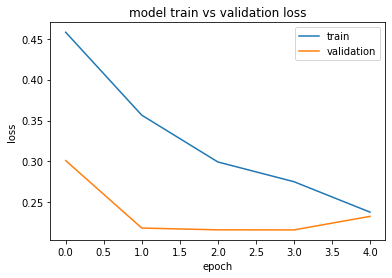

In [53]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
predict=rnn_model.predict(test_sequence)
predict=[int(x+0.5) for x in predict]

In [55]:
# EVALUATING THE ACCURACY
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

F1 Score: 76.16%
Accuracy: 78.21%
